In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()

from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

import chord_functions as cf

from sklearn.metrics import confusion_matrix

/home/sigis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Setup

In [2]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

#Load all data
data = pd.read_csv('data/updated_with_R.csv')

#Remove redundant attributes. Need to keep op to split
data = data[['chord', 'op']]

#Tranform the chords using one-hot encoding before separation so train and test have same # of features
data = pd.get_dummies(data)

#Separate one opus for testing purposes
opus = 131
test = data.loc[data['op'] == opus]
train = data.loc[data['op'] != opus]

#Remove the opus feature
test = test.drop(columns='op')
train = train.drop(columns='op')

test = test.head(10000)
train = train.head(10000)

# Sequence generation

In [3]:
#Create input sequences of length 10, predict the 11:th
seq_length = 10

train_in, train_out = cf.generate_sequences(train, train, seq_length)

test_in, test_out = cf.generate_sequences(test, test, seq_length)

# Model

In [4]:
def lstm(lstm_x, lstm_y, optimizer, loss, metrics):
    model = Sequential()
    
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    
    model.add(Dropout(0.5))
    
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    
    model.add(LSTM(64, return_sequences=False))
    
    model.add(Dropout(0.3))
    
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [5]:
#Define hyperparameters
optimizer = 'Adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

#Create model
model = lstm(train_in, train_out, optimizer, loss, metrics)

# Training

In [6]:
#Save the weights whenever validation accuracy is increased
checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='val_acc', 
    verbose=0,        
    save_best_only=True
)
# Stop the learning process if we havent improved validation accuracy for 10 epochs
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0)
callbacks_list = [checkpoint, earlystop]     

In [7]:
history = model.fit(train_in,
                    train_out,
                    epochs = 25,
                    verbose = 1,
                    validation_split = 0.1, 
                    callbacks = callbacks_list)

Train on 8990 samples, validate on 999 samples
Epoch 1/25
8990/8990 [==============================] - 70s 8ms/step - loss: 3.6026 - acc: 0.1123 - val_loss: 3.4609 - val_acc: 0.1331
Epoch 2/25
8990/8990 [==============================] - 68s 8ms/step - loss: 3.4365 - acc: 0.1328 - val_loss: 3.3627 - val_acc: 0.1522
Epoch 3/25
8990/8990 [==============================] - 67s 7ms/step - loss: 3.3890 - acc: 0.1434 - val_loss: 3.3503 - val_acc: 0.1592
Epoch 4/25
8990/8990 [==============================] - 68s 8ms/step - loss: 3.3560 - acc: 0.1485 - val_loss: 3.3174 - val_acc: 0.1682
Epoch 5/25
8990/8990 [==============================] - 67s 7ms/step - loss: 3.3245 - acc: 0.1580 - val_loss: 3.3377 - val_acc: 0.1672
Epoch 6/25
8990/8990 [==============================] - 66s 7ms/step - loss: 3.2943 - acc: 0.1636 - val_loss: 3.2876 - val_acc: 0.1592
Epoch 7/25
8990/8990 [==============================] - 69s 8ms/step - loss: 3.2585 - acc: 0.1712 - val_loss: 3.2434 - val_acc: 0.1712
Epoch 8/

KeyboardInterrupt: 

# Test

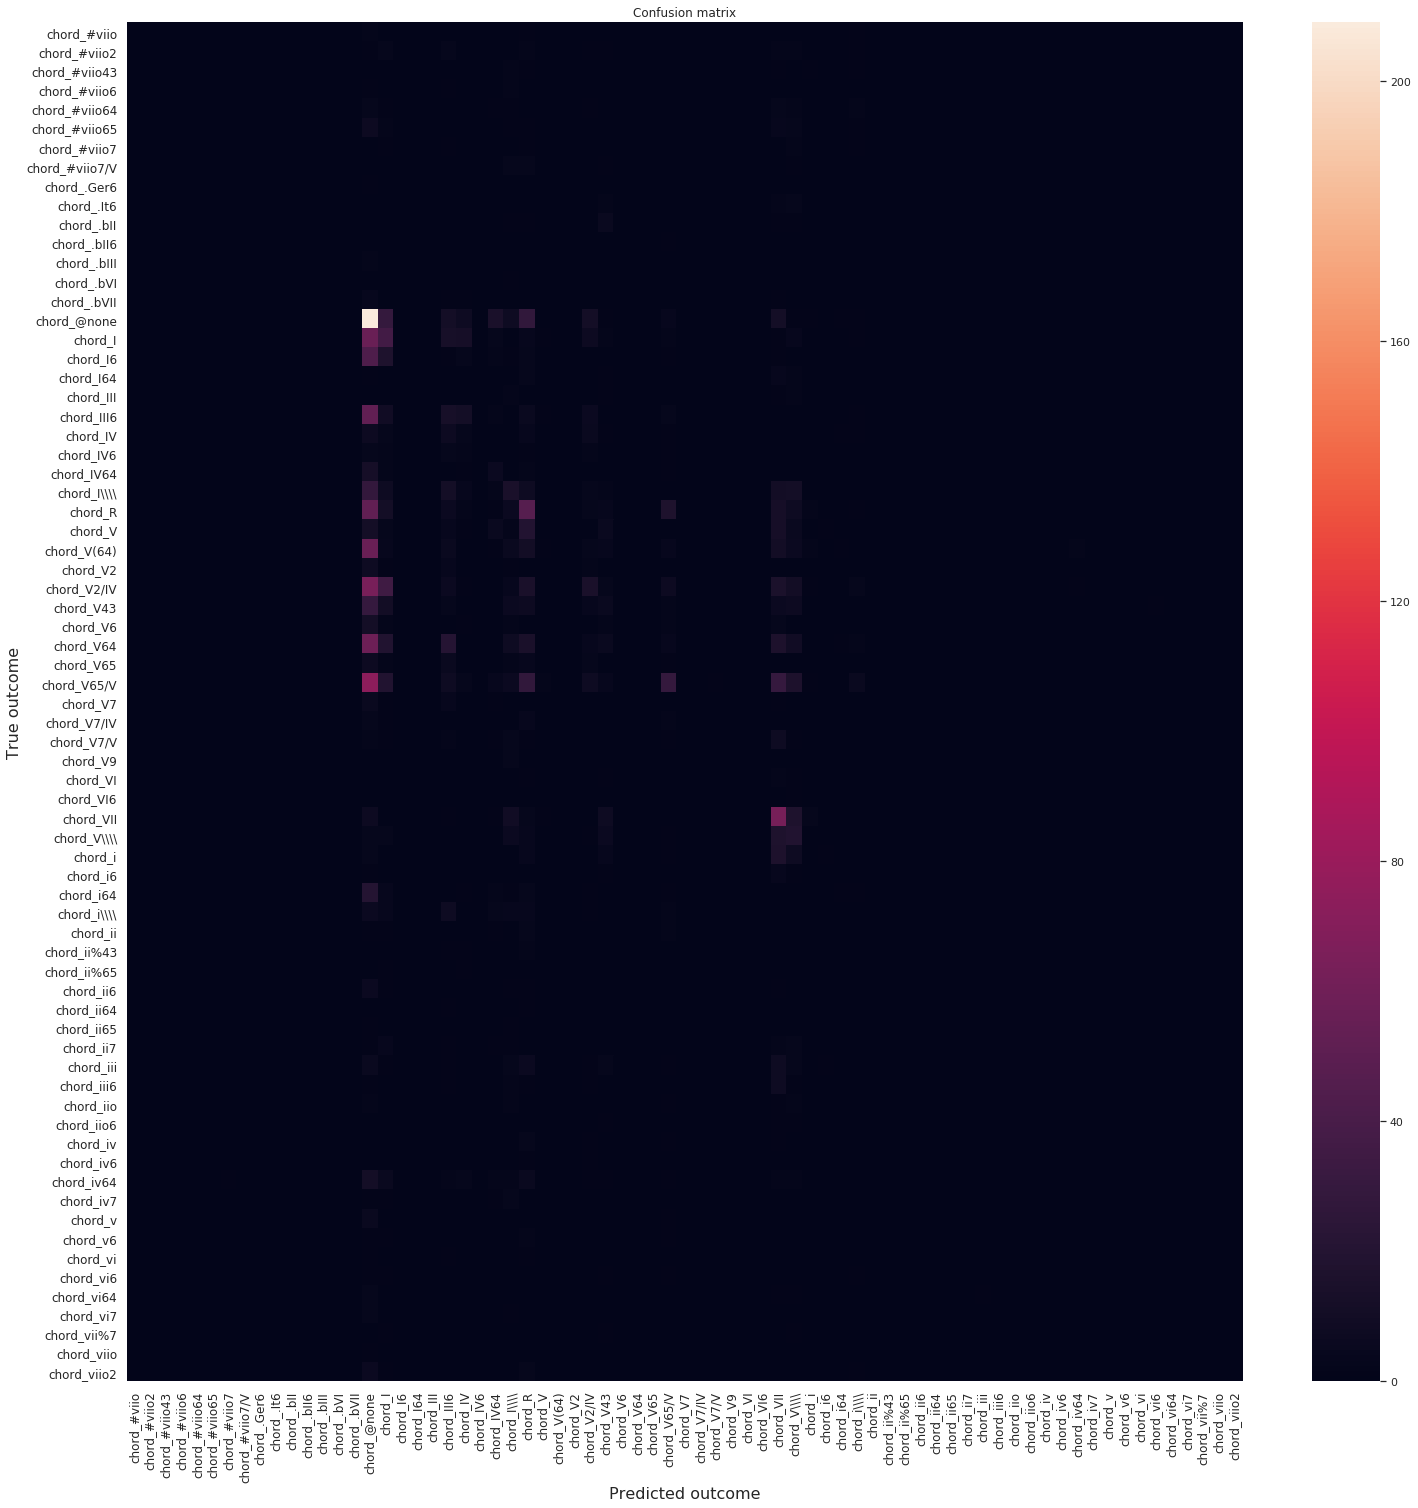

In [8]:
# Retrieve the probability distributions for the classes
prob_dist = model.predict(test_in)

# Attach them to the the chord names
prob_dist_df = pd.DataFrame(prob_dist, columns=test.columns.values)

#Single out the class that was given the highest likelihood for each sequence
predicted = prob_dist_df.idxmax(axis=1)

#Remap one-hot encoded labels to the actual chords
actual = pd.DataFrame(test_out, columns=test.columns.values).idxmax(axis=1)

c = confusion_matrix(actual, predicted)
fig, ax = plt.subplots(figsize = (25,25))
sns.heatmap(c, annot=False,  annot_kws={"size": 20}, fmt='d', cbar=True)
ax.set_title('Confusion matrix')
ax.set_xticklabels(test.columns.values, fontsize=12, rotation=90)
ax.set_yticklabels(test.columns.values, fontsize=12, rotation=0)
ax.set_xlabel('Predicted outcome', fontsize=16)
ax.set_ylabel('True outcome', fontsize=16)
plt.show()


# Results

## Learning Curves

In [ ]:
def disp_results(history_object):
    """
    Takes a history object and plots the evolution of the metrics as well as the final scores
    """
    history = history_object
    df = pd.DataFrame({'epochs': history.epoch,
                       'accuracy': history.history['acc'],
                       'validation_accuracy': history.history['val_acc'],
                       'loss': history.history['loss'], 
                       'val_loss': history.history['val_loss']})


    #Plot the the scores on the validation and training sets
    df.plot(x='epochs', y = ['validation_accuracy','accuracy'], figsize=[15,5])
    df.plot(x='epochs', y = ['val_loss','loss'], figsize=[15,5])

    a = history.history['acc'][-1]
    va= history.history['val_acc'][-1]
    l = history.history['loss'][-1]
    vl= history.history['val_loss'][-1]

    print("Final values\nacc\n{}\nvalacc\n{}\nloss\n{}\nvaloss\n{}\n".format(a, va, l, vl))
    
    print(history.model.summary())
    plt.show()
    
disp_results(history)

## Confusion Matrix for Predictions

## Comparison with human performance